## 4. Training

In this part of notebook we will try to train the model using feature extracted dataset and do model evaluation to see how well it predicts churn

### Setup Prerequisite

In [1]:
!pip install pyspark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Needed Library, Initialize Spark and Load Dataframe

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
spark = SparkSession.builder.appName('sparkify-train').getOrCreate()

In [5]:
# load data and change is_churn column into label column

isOnColab = True # CHANGE THIS VARIABLE IF RUNNING ON DATAPROC

path = '/content/drive/MyDrive/datasets/dsnd-sparkify/ml_df.parquet' if isOnColab else 'gs://udacity-dsnd/ml_df.parquet'
df = spark.read.parquet(path)
df = df.withColumn('label', F.when(F.col("is_churn"), 1).otherwise(0))
df.show(5)

+-------+-------------------+--------+----------+-------------+------------------+----------+-----------+---------+------------------+----------+-----+------+-----+-----+-------+-------+------------+-------------+----------+------------+-----+
| userId|              up_ts|is_churn|song_count|subs_duration|         song_rate|n_playlist|thumbs_down|thumbs_up|      avg_sess_len|sess_count| ipad|iphone|linux|macos|windows|n_error|n_friend_add|n_cancel_page|n_unq_song|n_unq_artist|label|
+-------+-------------------+--------+----------+-------------+------------------+----------+-----------+---------+------------------+----------+-----+------+-----+-----+-------+-------+------------+-------------+----------+------------+-----+
|1071843|2018-11-08 13:16:59|   false|      1190|           22| 54.09090909090909|        39|          6|       51|27020.272727272728|        11|false| false|false| true|  false|      1|          32|            0|      1104|         902|    0|
|1120784|2018-10-11 14:1

### Vectorize Feature and Do Train Test Split

In [6]:
# features columns
feature_cols = df.columns[3:-1]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# take only features and label column
df = df.select(["features", "label"])

In [7]:
train_df, test_df = df.randomSplit([0.9,0.1], seed=42)

In [8]:
print("train")
train_df.groupby("label").count().show()

print("test")
test_df.groupby("label").count().show()

train
+-----+-----+
|label|count|
+-----+-----+
|    1| 4470|
|    0| 9148|
+-----+-----+

test
+-----+-----+
|label|count|
+-----+-----+
|    1|  480|
|    0| 1037|
+-----+-----+



We have around 1:2 ratio between 1 and 0 label on both dataset. It shows that we have balanced train and test data split.

### Build Grid Search, Train Model and Predict Test Data

In this case we will use gradient boosted tree (GBT) algorithm to predic churn. I use GBT because it has good accuracy but still give us reasonable explainability. For hyperparameter tuning, I tune the tree depth and the number of trees. Then we choose the best model using pyspark built-in BinaryClassificationEvaluator with areaUnderROC metric,

In [9]:
train_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = false)



In [10]:
# ML algorithm
gbt = GBTClassifier() # GBT algorithm
rf = RandomForestClassifier() # RF algorithm

# Grid search parameter
gbt_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 6, 7]) \
    .addGrid(gbt.maxIter, [15, 20, 25]) \
    .build()

rf_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 6, 7]) \
    .addGrid(rf.numTrees, [15, 20, 25]) \
    .build()

# train validation split to search through all grid
gbt_tvs = TrainValidationSplit(estimator=gbt,
                            estimatorParamMaps=gbt_grid,
                            evaluator=BinaryClassificationEvaluator(),
                            trainRatio=0.75,
                            seed=42)

rf_tvs = TrainValidationSplit(estimator=rf,
                            estimatorParamMaps=rf_grid,
                            evaluator=BinaryClassificationEvaluator(),
                            trainRatio=0.75,
                            seed=42)

In [11]:
# train model
gbt_model = gbt_tvs.fit(train_df)
rf_model = rf_tvs.fit(train_df)

In [12]:
gbt_model.bestModel

GBTClassificationModel: uid = GBTClassifier_c80ab44a55a9, numTrees=25, numClasses=2, numFeatures=18

In [13]:
rf_model.bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_7d6f43fec27e, numTrees=25, numClasses=2, numFeatures=18

From the result above, the best model is using 25 trees and 7 depth

In [14]:
gbt_model.bestModel.featureImportances

SparseVector(18, {0: 0.0182, 1: 0.3157, 2: 0.1394, 3: 0.0331, 4: 0.0631, 5: 0.0654, 6: 0.0718, 7: 0.0867, 8: 0.0022, 9: 0.0006, 10: 0.0052, 11: 0.0055, 12: 0.0015, 13: 0.0159, 14: 0.0308, 15: 0.1226, 16: 0.0107, 17: 0.0118})

As seen above, the most important feature in gradient boost model are number 1 (subscription duration) with value 0.2645, number 2 (songs heard per day of subscription) with value 0.1197, number 7 (sessions count) with value 0.087 and number 15 (cancel confirmation page visit) with value 0.109

### Evaluate model

Before evaluate the prediction I create function to ease evaluation later on

In [15]:
def evaluate(df, label_col='label', pred_col='prediction'):
    '''
    INPUT:
    df - spark dataframe
    label_col - name of label column
    pred_col - name of prediction column

    OUTPUT:
    res - pandas dataframe of metrics
    '''

    temp_df = df.select([label_col, pred_col]).toPandas()
    
    return pd.DataFrame.from_dict({
        "accuracy" : [accuracy_score(temp_df[label_col], temp_df[pred_col])],
        "precision" : [precision_score(temp_df[label_col], temp_df[pred_col])],
        "recall" : [recall_score(temp_df[label_col], temp_df[pred_col])],
        "f1" : [f1_score(temp_df[label_col], temp_df[pred_col])],
        "roc_auc" : [roc_auc_score(temp_df[label_col], temp_df[pred_col])],
    })

In [16]:
# predict on test dataframe
preds_gbt_df = gbt_model.transform(test_df)
preds_rf_df = rf_model.transform(test_df)

In [17]:
# metrics result
evaluate(preds_gbt_df)

,accuracy,precision,recall,f1,roc_auc
0,0.779169,0.649485,0.65625,0.65285,0.746158


In [18]:
evaluate(preds_rf_df)

,accuracy,precision,recall,f1,roc_auc
0,0.773896,0.650549,0.616667,0.633155,0.73167


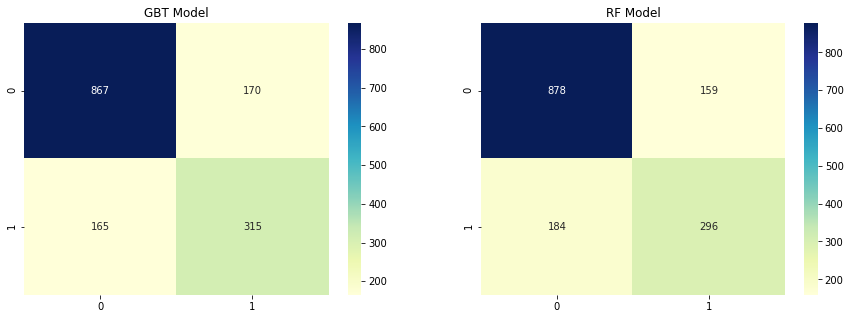

In [30]:
# confusion matrix
c_mat_gbt = confusion_matrix(preds_gbt_df.select("label").toPandas(),
                preds_gbt_df.select("prediction").toPandas())
c_mat_rf = confusion_matrix(preds_rf_df.select("label").toPandas(),
                preds_rf_df.select("prediction").toPandas())


fig, axes = plt.subplots(1,2, figsize=(15,5))

sns.heatmap(c_mat_gbt, annot=True, fmt="d", cmap="YlGnBu", ax=axes[0])
sns.heatmap(c_mat_rf, annot=True, fmt="d", cmap="YlGnBu", ax=axes[1])

axes[0].title.set_text("GBT Model")
axes[1].title.set_text("RF Model")

With metrics shown above, We got good f1 and roc auc score. But as you see in the confusion matrix, accuracy value is mostly driven by high true negative value. But We are more concerned about true positive value so we can prevent user from churning. If We want to see how good our model predict churn we can calculate with recall score (312 / (312 + 168)) and get the value of 65%.

### Train Model with Weighted Dataset

Since we are more concerned on increase true positive value, I will use weighted dataset to retrain the model. If the label is negative, I give 0.7 value and positive 1 value.

In [20]:
# add weight column
train_df_w = train_df.withColumn("weight", F.when(F.col("label") == 1, 1).otherwise(0.7))
train_df_w.show(5)

+--------------------+-----+------+
|            features|label|weight|
+--------------------+-----+------+
|(18,[0,1,2,3,4,6,...|    0|   0.7|
|(18,[0,1,2,3,4,6,...|    0|   0.7|
|(18,[0,1,2,3,4,6,...|    0|   0.7|
|(18,[0,1,2,3,4,6,...|    0|   0.7|
|(18,[0,1,2,3,4,6,...|    0|   0.7|
+--------------------+-----+------+
only showing top 5 rows



I use the same model, grid and validation method as before but We need to specify weight column name so they can use it in training process.

In [21]:
# gradient boosted tree algorithm
gbt_w = GBTClassifier().setWeightCol("weight")
rf_w = RandomForestClassifier(weightCol="weight")

# train validation split to search through all grid
gbt_tvs_w = TrainValidationSplit(estimator=gbt_w,
                            estimatorParamMaps=gbt_grid,
                            evaluator=BinaryClassificationEvaluator().setWeightCol("weight"),
                            trainRatio=0.75,
                            seed=42)

rf_tvs_w = TrainValidationSplit(estimator=rf_w,
                            estimatorParamMaps=rf_grid,
                            evaluator=BinaryClassificationEvaluator().setWeightCol("weight"),
                            trainRatio=0.75,
                            seed=42)

In [23]:
# train model with weighted dataset
gbt_model_w = gbt_tvs_w.fit(train_df_w)
rf_model_w = rf_tvs_w.fit(train_df_w)

In [ ]:
gbtw_model.bestModel

GBTClassificationModel: uid = GBTClassifier_9513161e1f7b, numTrees=20, numClasses=2, numFeatures=18

After training the model is using 20 trees and 7 tree depth

In [ ]:
gbtw_model.bestModel.featureImportances

SparseVector(18, {0: 0.0045, 1: 0.368, 2: 0.1857, 3: 0.0058, 4: 0.0317, 5: 0.0386, 6: 0.0849, 7: 0.1224, 8: 0.0022, 9: 0.0009, 10: 0.0038, 11: 0.0001, 12: 0.0014, 13: 0.0039, 14: 0.0114, 15: 0.1271, 16: 0.0048, 17: 0.0028})

As seen above, the most influencing features are subscription duration, songs played per day, session count and number of cancellation confirmation page visited. The same as model before but with different value

### Evaluate Weighted Model

In [24]:
# predict using weighted model
preds_gbt_w_df = gbt_model_w.transform(test_df)
preds_rf_w_df = rf_model_w.transform(test_df)

In [25]:
evaluate(preds_gbt_w_df)

,accuracy,precision,recall,f1,roc_auc
0,0.792353,0.646018,0.760417,0.698565,0.783776


In [26]:
evaluate(preds_rf_w_df)

,accuracy,precision,recall,f1,roc_auc
0,0.763349,0.613936,0.679167,0.644906,0.740741


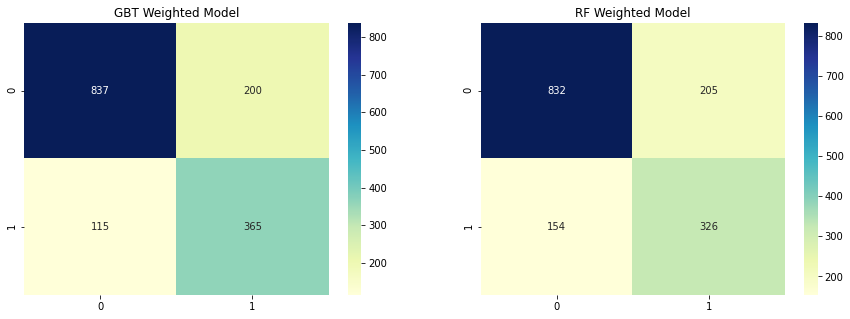

In [31]:
# confusion matrix
c_mat_gbt_w = confusion_matrix(preds_gbt_w_df.select("label").toPandas(),
                preds_gbt_w_df.select("prediction").toPandas())
c_mat_rf_w = confusion_matrix(preds_rf_w_df.select("label").toPandas(),
                preds_rf_w_df.select("prediction").toPandas())


fig, axes = plt.subplots(1,2, figsize=(15,5))

sns.heatmap(c_mat_gbt_w, annot=True, fmt="d", cmap="YlGnBu", ax=axes[0])
sns.heatmap(c_mat_rf_w, annot=True, fmt="d", cmap="YlGnBu", ax=axes[1])

axes[0].title.set_text("GBT Weighted Model")
axes[1].title.set_text("RF Weighted Model")

As seen above all the metrics produce better result, especially recall score. But on the down side the number of true negative reduced.